In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mxnet as mx
from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from typing import List, Optional, Any
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gluonts
import optuna
from IPython.display import display, HTML
import time
import warnings

warnings.filterwarnings("ignore")

class DeepARForecasting:
    def __init__(self, start_date: str, freq: str = 'ME', prediction_length: int = 5, epochs: int = 50, num_batches_per_epoch: int = 100):
        self.start_date = pd.Timestamp(start_date)
        self.freq = freq
        self.prediction_length = prediction_length
        self.epochs = epochs
        self.num_batches_per_epoch = num_batches_per_epoch
        self.time_series = []
        self.titles = []
        self.train_ds = None
        self.predictor = None
        
        # Set seeds for reproducibility
        np.random.seed(42)
        mx.random.seed(42)

    def add_time_series(self, series: np.ndarray, title: str):
        self.time_series.append(series)
        self.titles.append(title)

    def prepare_dataset(self):
        self.train_ds = ListDataset(
            [{"start": self.start_date, "target": series[:-self.prediction_length]} for series in self.time_series],
            freq=self.freq
        )


    class DeepARTuningObjective:
        def __init__(self, dataset, prediction_length, freq, metric_type="mean_wQuantileLoss"):
            self.dataset = dataset
            self.prediction_length = prediction_length
            self.freq = freq
            self.metric_type = metric_type

            self.train, test_template = gluonts.dataset.split.split(dataset, offset=-prediction_length)
            validation = test_template.generate_instances(prediction_length=prediction_length)
            self.validation_input = [entry[0] for entry in validation]
            self.validation_label = [self.dataentry_to_dataframe(entry[1]) for entry in validation]

        @staticmethod
        def dataentry_to_dataframe(entry):
            return pd.DataFrame(
                entry["target"],
                columns=[entry.get("item_id")],
                index=pd.period_range(
                    start=entry["start"], periods=len(entry["target"]), freq=entry["start"].freq
                ),
            )

        def __call__(self, trial):
            num_layers = trial.suggest_int("num_layers", 1, 2)
            neurons_per_layer = trial.suggest_categorical("neurons_per_layer", [8, 16, 32])

            estimator = DeepAREstimator(
                num_layers=num_layers,
                num_cells=neurons_per_layer,  # Now using a single integer value
                prediction_length=self.prediction_length,
                freq=self.freq,
                trainer=Trainer(epochs=10, num_batches_per_epoch=100)
            )

            predictor = estimator.train(self.train)
            forecast_it = predictor.predict(self.validation_input)
            forecasts = list(forecast_it)

            evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
            agg_metrics, _ = evaluator(self.validation_label, forecasts, num_series=len(self.dataset))
            return agg_metrics[self.metric_type]

    def train_model(self, **params):
        estimator = DeepAREstimator(
            freq=self.freq,
            prediction_length=self.prediction_length,
            trainer=Trainer(epochs=self.epochs, num_batches_per_epoch=self.num_batches_per_epoch),
            num_layers=params.get('num_layers', 2),
            num_cells=params.get('neurons_per_layer', 40)  # Now using a single integer value
        )
        return estimator.train(self.train_ds)

    def tune_hyperparameters(self, n_trials=5):
        start_time = time.time()
        study = optuna.create_study(direction="minimize")
        study.optimize(
            self.DeepARTuningObjective(
                self.train_ds, self.prediction_length, self.freq
            ),
            n_trials=n_trials
        )

        print("Number of finished trials: {}".format(len(study.trials)))
        print("\nBest trial:")
        trial = study.best_trial
        print("  Value: {}".format(trial.value))
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))
        print("Time taken: {:.2f} seconds".format(time.time() - start_time))

        return trial.params, trial.value

    def make_predictions(self, predictor, series_index: int = 0):
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=ListDataset(
                [{"start": self.start_date, "target": self.time_series[series_index][:-self.prediction_length]}],
                freq=self.freq
            ),
            predictor=predictor,
            num_samples=100
        )
    
        forecasts = list(forecast_it)
        tss = list(ts_it)
    
        # Extract the actual test data
        test_data = self.time_series[series_index][-self.prediction_length:]
    
        # Create a DatetimeIndex for the test data
        test_dates = pd.date_range(start=self.start_date + pd.Timedelta(days=len(self.time_series[series_index]) - self.prediction_length), 
                                periods=self.prediction_length, 
                                freq=self.freq)
    
        # Create the test_data Series with the correct DatetimeIndex
        test_data = pd.Series(test_data, index=test_dates)
        display(test_data)
        plt.plot(test_data)
        plt.show()
    
        return forecasts[0], test_data

    def plot_prediction_distribution(self, forecast, test_data: pd.Series, title: str, bw_method: Optional[Any] = None, **fig_kw):
        samples = forecast.samples
        prediction_length = samples.shape[1]
        
        figsize = fig_kw.pop('figsize', (12, 4*prediction_length))
        
        fig, axs = plt.subplots(prediction_length, 1, figsize=figsize, sharex=True, **fig_kw)
        if not isinstance(axs, np.ndarray):
            axs = np.array([axs])
        
        palette = sns.color_palette("viridis", prediction_length)
        
        legend_handles = []
        legend_labels = []
        
        for i in range(prediction_length):
            step_samples = samples[:, i]
            
            sns.kdeplot(data=step_samples, ax=axs[i], fill=True, color=palette[i])
            
            prediction_mean = np.mean(step_samples)
            mean_line = axs[i].axvline(x=prediction_mean, color='black', linestyle='--', linewidth=2)
            
            quantiles = [0.1, 0.5, 0.9]
            quantile_values = np.quantile(step_samples, quantiles)
            quantile_lines = [axs[i].axvline(x=q, color='green', linestyle=':', linewidth=1) for q in quantile_values]
            
            real_value = test_data.iloc[i]
            actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2)
            
            axs[i].spines['top'].set_visible(False)
            axs[i].spines['right'].set_visible(False)
            axs[i].set_ylabel(f'Step {i+1}')
            axs[i].set_xlabel('Prediction')
            
            if i == 0:
                legend_handles.extend([mean_line, actual_line, quantile_lines[1]])
                legend_labels.extend(['Prediction Mean', 'Actual Value', 'Median (50% quantile)'])
        
        fig.subplots_adjust(hspace=0.4)
        fig.suptitle(f"DeepAR Forecasting Distribution per Step - {title}")
        
        fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)
        
        plt.show()

    def print_prediction_summary(self, forecast, test_data, title: str):
        mean_forecast = forecast.mean
        median_forecast = forecast.quantile(0.5)
        lower_quantile = forecast.quantile(0.1)
        upper_quantile = forecast.quantile(0.9)
        
        print(f"Resumen de predicciones para {title}:")
        for i in range(len(mean_forecast)):
            print(f"\nPaso {i+1}:")
            print(f"  Valor real: {test_data.iloc[i]:.2f}")
            print(f"  Predicción media: {mean_forecast[i]:.2f}")
            print(f"  Predicción mediana: {median_forecast[i]:.2f}")
            print(f"  Intervalo de predicción (80%): [{lower_quantile[i]:.2f}, {upper_quantile[i]:.2f}]")

    def plot_actual_vs_predicted(self, forecast, test_data, train_data, title: str):
        mean_forecast = forecast.mean
        lower_quantile = forecast.quantile(0.1)
        upper_quantile = forecast.quantile(0.9)
        
        # Create separate DataFrames for train and test data
        train_df = pd.DataFrame({'date': train_data.index, 'value': train_data.values})
        
        # Create test_df using the forecast dates
        forecast_dates = pd.date_range(start=train_df['date'].max() + pd.Timedelta(days=30), periods=len(mean_forecast), freq=self.freq)
        test_df = pd.DataFrame({'date': forecast_dates, 'value': test_data.values})
        
        # Create DataFrame for forecast
        forecast_df = pd.DataFrame({
            'date': forecast_dates,
            'mean': mean_forecast,
            'lower': lower_quantile,
            'upper': upper_quantile
        })
        
        fig = make_subplots(specs=[[{"secondary_y": False}]])
        
        # Plot training data
        fig.add_trace(
            go.Scatter(x=train_df['date'], y=train_df['value'], name="Training Data", line=dict(color='blue'))
        )
        
        # Plot test data
        fig.add_trace(
            go.Scatter(x=test_df['date'], y=test_df['value'], name="Actual", mode='lines+markers', marker=dict(color='red', size=8))
        )
        
        # Plot mean forecast
        fig.add_trace(
            go.Scatter(x=forecast_df['date'], y=forecast_df['mean'], name="Predicted (mean)", mode='lines+markers', line=dict(color='green'))
        )
        
        # Plot prediction interval
        fig.add_trace(
            go.Scatter(
                x=forecast_df['date'].tolist() + forecast_df['date'][::-1].tolist(),
                y=forecast_df['upper'].tolist() + forecast_df['lower'][::-1].tolist(),
                fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo="skip",
                showlegend=True,
                name="80% Prediction Interval"
            )
        )
        
        fig.update_layout(
            title=f"Actual vs Predicted Values (with Training Data) - {title}",
            xaxis_title="Date",
            yaxis_title="Value",
            legend_title="Legend",
            hovermode="x unified"
        )
        
        fig.show()

    def plot_input_series(self):
        """
        Plot all input time series.
        """
        n_series = len(self.time_series)
        fig, axs = plt.subplots(n_series, 1, figsize=(12, 4*n_series), sharex=True)
        
        if n_series == 1:
            axs = [axs]
        
        for i, (series, title) in enumerate(zip(self.time_series, self.titles)):
            dates = pd.date_range(start=self.start_date, periods=len(series), freq=self.freq)
            axs[i].plot(dates, series)
            axs[i].set_title(f"Input Time Series: {title}")
            axs[i].set_xlabel("Date")
            axs[i].set_ylabel("Value")
            
        plt.tight_layout()
        plt.show()

    def run_forecasting_process(self, series_index: int = 0, n_trials: int = 5):
        self.plot_input_series()
        self.prepare_dataset()
        
        print("Starting hyperparameter tuning...")
        best_params, best_value = self.tune_hyperparameters(n_trials)
        
        print("\nTraining model with best parameters...")
        self.predictor = self.train_model(**best_params)
        
        forecast, test_data = self.make_predictions(self.predictor, series_index)
        
        train_data = pd.Series(
            self.time_series[series_index][:-self.prediction_length],
            index=pd.date_range(start=self.start_date, periods=len(self.time_series[series_index])-self.prediction_length, freq=self.freq)
        )
        
        title = self.titles[series_index]
        self.plot_prediction_distribution(forecast, test_data, title)
        self.print_prediction_summary(forecast, test_data, title)
        self.plot_actual_vs_predicted(forecast, test_data, train_data, title)

        # Display results of hyperparameter optimization
        results = f"""
        <h3>Hyperparameter Optimization Results</h3>
        <p>The best hyperparameters found during the optimization process are:</p>
        <ul>
            <li>Number of layers: {best_params['num_layers']}</li>
            <li>Neurons per layer: {best_params['neurons_per_layer']}</li>
        </ul>
        <p>The optimization value (mean weighted quantile loss) achieved with these parameters is: {best_value:.4f}</p>
        <p>This optimization aims to minimize the mean weighted quantile loss, which measures the accuracy of the probabilistic forecasts across different quantiles.</p>
        """
        display(HTML(results))

/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


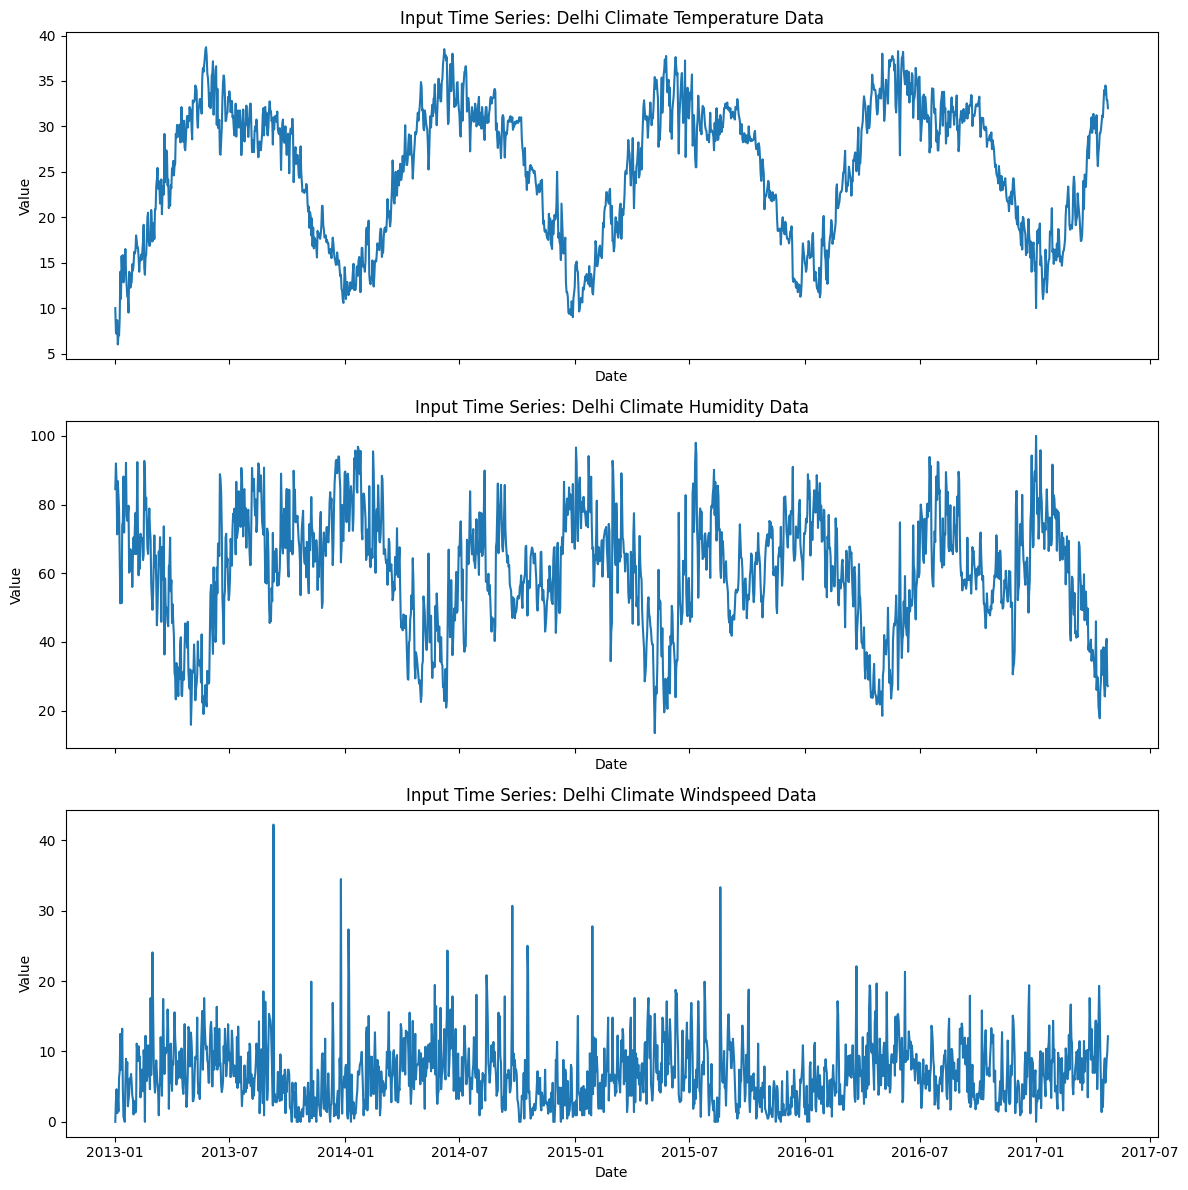

[I 2024-09-24 16:32:50,272] A new study created in memory with name: no-name-9fd358af-be1c-4a49-a0de-7c4cbf854fe4


Starting hyperparameter tuning...


Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 19.18it/s]
[I 2024-09-24 16:34:42,240] Trial 0 finished with value: 0.1080963953123198 and parameters: {'num_layers': 1, 'neurons_per_layer': 8}. Best is trial 0 with value: 0.1080963953123198.
Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 19.02it/s]
[I 2024-09-24 16:39:02,388] Trial 1 finished with value: 0.10950636431912754 and parameters: {'num_layers': 2, 'neurons_per_layer': 32}. Best is trial 0 with value: 0.1080963953123198.


Number of finished trials: 2

Best trial:
  Value: 0.1080963953123198
  Params: 
    num_layers: 1
    neurons_per_layer: 8
Time taken: 372.12 seconds

Training model with best parameters...


100%|██████████| 100/100 [00:10<00:00,  9.14it/s, epoch=5/5, avg_epoch_loss=2.82]


2017-01-02    18.500000
2017-01-03    17.111111
2017-01-04    18.700000
2017-01-05    18.388889
2017-01-06    19.318182
                ...    
2017-04-21    34.250000
2017-04-22    32.900000
2017-04-23    32.875000
2017-04-24    32.000000
2017-04-25          NaN
Freq: D, Name: meantemp, Length: 114, dtype: float64

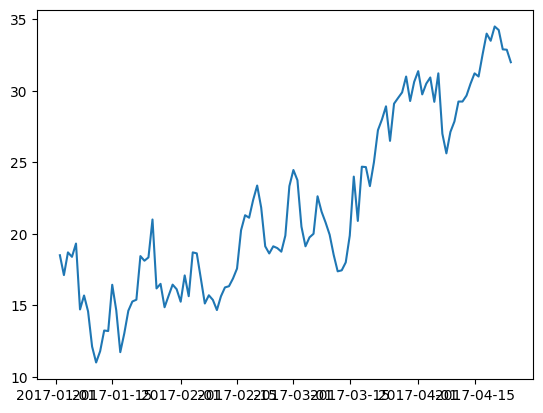

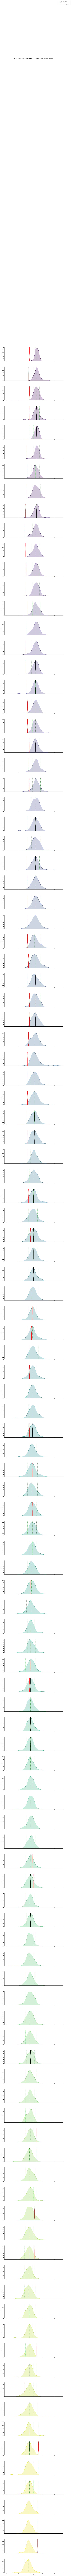

Resumen de predicciones para Delhi Climate Temperature Data:

Paso 1:
  Valor real: 18.50
  Predicción media: 30.94
  Predicción mediana: 30.79
  Intervalo de predicción (80%): [27.80, 34.37]

Paso 2:
  Valor real: 17.11
  Predicción media: 31.22
  Predicción mediana: 30.80
  Intervalo de predicción (80%): [25.88, 36.27]

Paso 3:
  Valor real: 18.70
  Predicción media: 29.69
  Predicción mediana: 30.22
  Intervalo de predicción (80%): [25.55, 35.21]

Paso 4:
  Valor real: 18.39
  Predicción media: 30.10
  Predicción mediana: 29.91
  Intervalo de predicción (80%): [25.05, 35.22]

Paso 5:
  Valor real: 19.32
  Predicción media: 30.18
  Predicción mediana: 30.72
  Intervalo de predicción (80%): [25.14, 34.92]

Paso 6:
  Valor real: 14.71
  Predicción media: 30.62
  Predicción mediana: 30.90
  Intervalo de predicción (80%): [25.79, 35.23]

Paso 7:
  Valor real: 15.68
  Predicción media: 28.86
  Predicción mediana: 28.47
  Intervalo de predicción (80%): [22.22, 35.25]

Paso 8:
  Valor real:

In [3]:
# Load the training and test data
df_train = pd.read_csv('./data/DailyDelhiClimateTrain.csv', parse_dates=['date'])
df_test = pd.read_csv('./data/DailyDelhiClimateTest.csv', parse_dates=['date'])

# Concatenate the training and test data
df_final = pd.concat([df_train, df_test], ignore_index=True)

# Create the time series
df_series = df_final.set_index('date')['meantemp']
df_series1 = df_final.set_index('date')['humidity']
df_series2 = df_final.set_index('date')['wind_speed']

# Titles of the series
titles = ['Delhi Climate Temperature Data', 'Delhi Climate Humidity Data', 
          'Delhi Climate Windspeed Data']

# List of the time series
time_series = [df_series, df_series1, df_series2]

# Crear el forecaster de DeepAR con las configuraciones adecuadas
forecaster = DeepARForecasting(start_date="2013-01-01", freq="D", prediction_length=len(df_test), epochs=5)

# Agregar las series temporales al forecaster
for series, title in zip(time_series, titles):
    forecaster.add_time_series(series, title)

# Realizar el proceso de forecasting
results = forecaster.run_forecasting_process(series_index=0, n_trials=2)